In [3]:
import matplotlib.pyplot as plt
from ale_py import ALEInterface
from ale_py.roms import Breakout
import tensorflow as tf
import numpy as np
from atari_wrappers import make_atari, wrap_deepmind

ale = ALEInterface()
ale.loadROM(Breakout)

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]
Game console created:
  ROM file:  /Users/mfidabel/Codigos/materias/ML/TP-ATARI/venv/lib/python3.8/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1636902272


In [9]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

(42, 742738649)

In [12]:
num_actions = 4

def create_q_network():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(84, 84, 4, )),
        tf.keras.layers.Conv2D(32, 8, strides=4, activation="relu"),
        tf.keras.layers.Conv2D(64, 4, strides=2, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, strides=1, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(num_actions, activation="linear")
    ])

    return model

model = create_q_network()
model_target = create_q_network()

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = tf.keras.losses.Huber()

In [7]:
# No se usa al final
def atari_preprocessing(state: np.array):
    state = tf.convert_to_tensor(state)
    state = tf.image.rgb_to_grayscale(state)
    state = tf.image.resize(state, [110, 84])
    state = state[17:-9,:,:]
    return state

In [14]:
while True:
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Jugamos exploración
            action = np.random.choice(num_actions)
        else:
            # Jugamos explotación
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Tomar mejor acción
            action = tf.argmax(action_probs[0]).numpy()

        # Decaer probabilidad de tomar una acción aleatoria
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Aplicar la acción seleccionada
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Guardar al replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            indices = np.random.choice(range(len(done_history)), size=batch_size)

            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

         # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 0.29 at episode 288, frame count 10000


KeyboardInterrupt: 

(84, 84, 1)


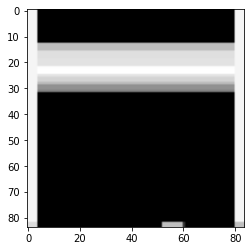

In [39]:
test_np = tf.constant(test)
state = tf.image.rgb_to_grayscale(test_np)
state = tf.image.resize(state, [110, 84])
state = state[17:-9,:,:]
print(state.shape)
plt.imshow(state.numpy(), cmap='gray')

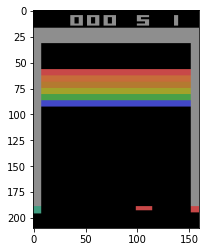

In [37]:
plt.imshow(xd[0])

In [59]:
env.spec.

EnvSpec(ALE/Breakout-v5)